# A Piecewise Proliferation Law

In this section, we show how we reproduced the results from Section 3.3
of [Murphy et al. (2020)](https://doi.org/10.1007/s11538-020-00807-x),
and how we learned the appropriate continuum model describing these results. In
this section, the force law $F(\ell_i) = k(s - \ell_i)$ is used, and the
proliferation law is given by
$$
G(\ell_i) = \begin{cases} 0 & 0 \leq \ell_i < \ell_p, \\ \beta & \ell_i \geq \ell_p, \end{cases}
$$
where $\ell_p = 0.2$ and $\beta=0.01$. Murphy et al. start with $41$ nodes initially,
spaced such that $\ell_i = 0.25$ for each $i$. To start,
let us setup the `CellProblem`, first loading in the packages
we will need.

In [1]:
using StepwiseEQL
using CairoMakie
using EpithelialDynamics1D
using OrdinaryDiffEq
using LinearSolve
using Random
using DataInterpolations

The `CellProblem` is defined as follows.

In [2]:
final_time = 500.0
domain_length = 10.0
initial_condition = collect(0:0.25:domain_length)
η = 1.0
s = 0.0
k = 0.0001
Δt = 1e-2
ℓp = 0.2
β = 0.01
Fp = (s=s, k=k)
F = (δ, p) -> p.k * (p.s - δ)
Gp = (ℓp=ℓp, β=β)
G = (δ, p) -> δ ≥ p.ℓp ? p.β : 0.0
prob = CellProblem(;
    final_time,
    initial_condition,
    damping_constant=η,
    force_law=F,
    force_law_parameters=Fp,
    proliferation_law=G,
    proliferation_period=Δt,
    proliferation_law_parameters=Gp,
    fix_right=true)
Random.seed!(123)
ens_prob = EnsembleProblem(prob)
saveat = 0.1
esol = solve(ens_prob, Tsit5(), EnsembleSerial(); trajectories=1000, saveat=saveat)

EnsembleSolution Solution of length 1000 with uType:
ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, CellProblem{var"#11#12", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, var"#13#14", NamedTuple{(:ℓp, :β), Tuple{Float64, Float64}}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, CellProblem{var"#11#12", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, var"#13#14", NamedTuple{(:ℓp, :β), Tuple{Float64, Float64}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, CellProblem{var"#11#12", NamedTuple{(:s, :k), Tuple{Float64, Float64}}, var

Now let us compare the discrete results to the continuum limit model's solution.

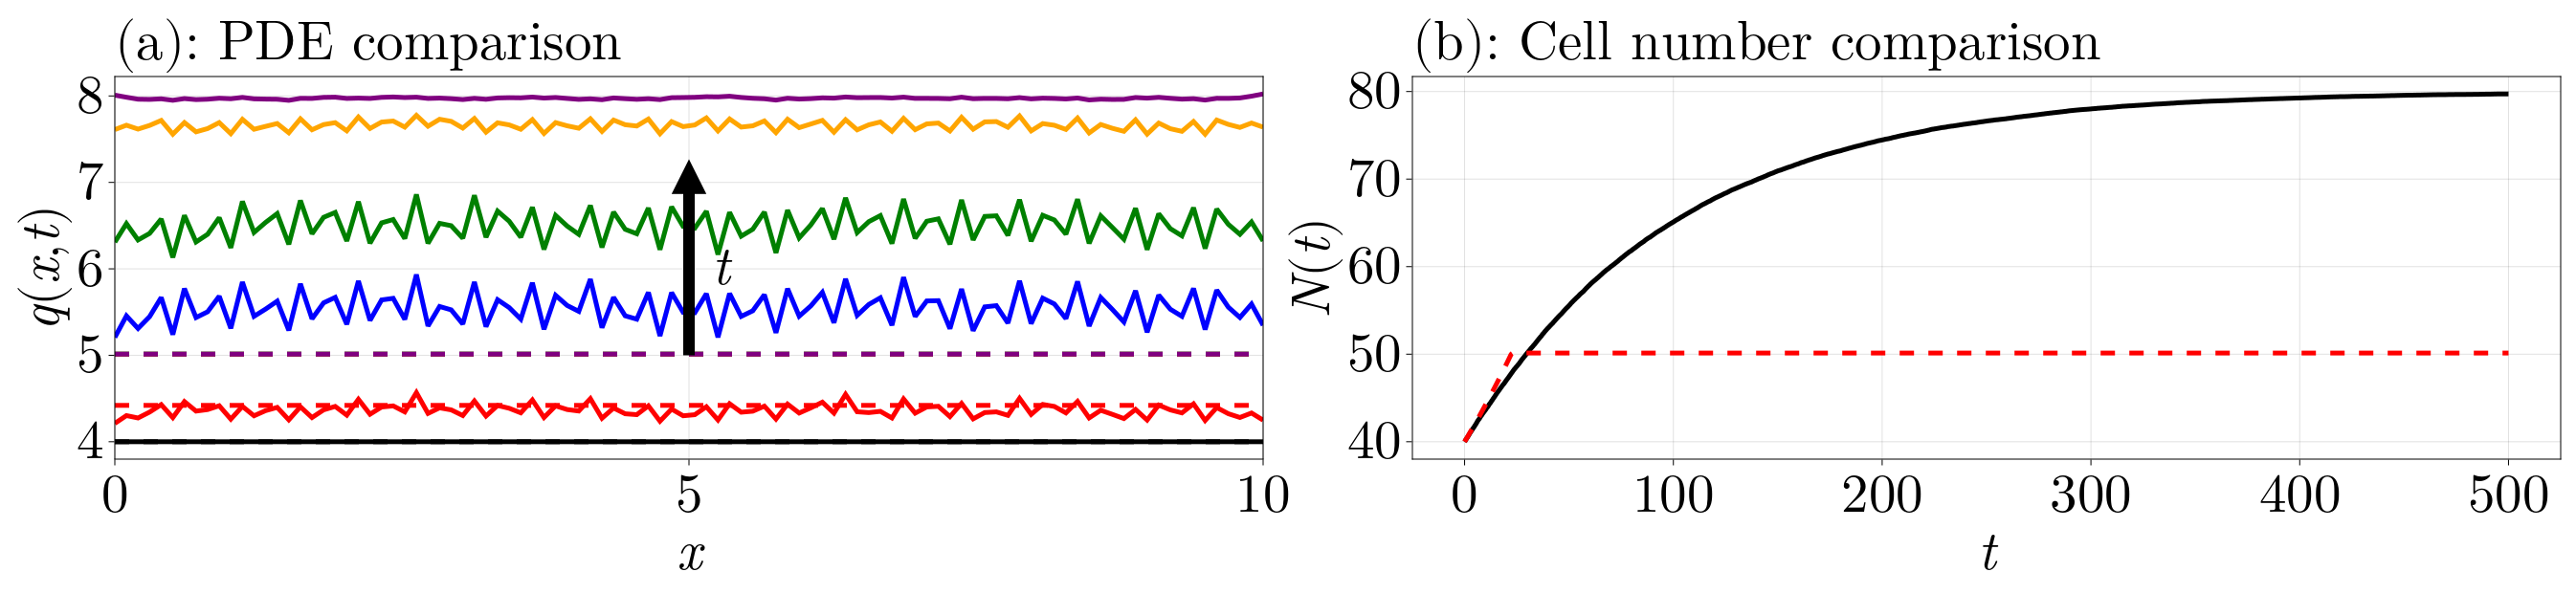

In [3]:
density_results = node_densities_means_only(esol, num_knots=100)
number_results = cell_numbers(esol)
pde = continuum_limit(prob, 1000, proliferation=true)
pde_sol = solve(pde, TRBDF2(linsolve=KLUFactorization()), saveat=esol[1].t)
pde_number_results = [integrate_pde(pde_sol, i) for i in eachindex(pde_sol)]
t = (0.0, 10.0, 50.0, 100.0, 250.0, 500.0)
colors = (:black, :red, :blue, :green, :orange, :purple)
t_idx = [findlast(≤(τ), esol[1].t) for τ in t]
fig = Figure(fontsize=57)
ax1 = Axis(fig[1, 1], xlabel=L"x", ylabel=L"q(x, t)",
    title=L"(a):$ $ PDE comparison", titlealign=:left,
    width=1200, height=400,
    xticks=(0:5:10, [L"%$s" for s in 0:5:10]),
    yticks=(4:8, [L"%$s" for s in 4:8]))
ax2 = Axis(fig[1, 2], xlabel=L"t", ylabel=L"N(t)",
    title=L"(b):$ $ Cell number comparison", titlealign=:left,
    width=1200, height=400,
    xticks=(0:100:500, [L"%$s" for s in 0:100:500]),
    yticks=(40:10:80, [L"%$s" for s in 40:10:80]))
for (j, i) in enumerate(t_idx)
    lines!(ax1, density_results.knots[i], density_results.means[i], color=colors[j], linewidth=5)
    lines!(ax1, pde.geometry.mesh_points, pde_sol.u[i], color=colors[j], linewidth=5, linestyle=:dash)
end
xlims!(ax1, 0, 10)
arrows!(ax1, [5.0], [5.0], [0.0], [2.0], color=:black, linewidth=12, arrowsize=50)
text!(ax1, [5.2], [5.7], text=L"t", color=:black, fontsize=57)
lines!(ax2, esol[1].t, number_results.means, color=:black, linewidth=5)
lines!(ax2, esol[1].t, pde_number_results, color=:red, linewidth=5, linestyle=:dash)
resize_to_layout!(fig)
fig

Obviously, the continuum limit is not working in this case.
We are interested in learning a continuum model for this problem. To know what
basis to use for $D(q)$ and $R(q)$, we know that in cases where the continuum
limit is accurate we would expect
$$
\begin{align*}
D(q) &= \alpha/q^2, \\
R(q) &= \begin{cases} 0 & q > 1/\ell_p, \\ \beta q & q \leq 1/\ell_p, \end{cases}
\end{align*}
$$
where $\alpha=k/\eta$. We can write this $R(q)$ as
$$
R(q) = \beta q\mathbb I\left(q \leq \frac{1}{\ell_p}\right),
$$
where $\mathbb I(A)$ is the indicator function for the set $A$. We could use this
representation as an inspiration for the basis functions to use, for example we could consider
$$
R(q) = \left[\theta_1^rq + \theta_2^rq^2 + \theta_3^rq^3\right]\mathbb I\left(q \leq \frac{1}{\ell_p}\right).
$$
We instead find that this does not lead to any improved model. Instead, we find that working with
a polynomial model is appropriate, where we write
$$
R(q) = \theta_0^r + \theta_1^rq + \theta_2^rq^2 + \theta_3^rq^3 + \theta_4^rq^4 + \theta_5^rq^5.
$$
For $D(q)$, this mechanism does not appear to be relevant in this example,
with all results visually indistinguishable regardless of whether $D(q) = 0$ or $D(q) = \alpha/q^2$.
Thus, we do not bother learning it in this case, simply fixing $D(q) = \alpha/q^2$; if we do not fix $D(q)$,
we just learn $D(q) = 0$. We define the bases using `PolynomialBasis`:

In [4]:
diffusion_basis = PolynomialBasis(-2, -2)
reaction_basis = PolynomialBasis(0, 5)

(::BasisSet{NTuple{6, StepwiseEQL.var"#52#54"{Int64}}}) (generic function with 3 methods)

Let us now learn the equations.

In [5]:
eql_sol = stepwise_selection(esol; diffusion_basis, reaction_basis,
    diffusion_theta=[k], initial=:none)

StepwiseEQL Solution.
    R(q) = θ₁ʳ ϕ₁ʳ(q) + θ₂ʳ ϕ₂ʳ(q)
┌──────┬─────────────────────────────────────┬───────┐
│ Step │  θ₁ʳ    θ₂ʳ   θ₃ʳ   θ₄ʳ   θ₅ʳ   θ₆ʳ │  Loss │
├──────┼─────────────────────────────────────┼───────┤
│    1 │ 0.00   0.00  0.00  0.00  0.00  0.00 │ -1.63 │
│    2 │ 0.01   0.00  0.00  0.00  0.00  0.00 │ -2.33 │
│    3 │ 0.08  -0.01  0.00  0.00  0.00  0.00 │ -6.24 │
└──────┴─────────────────────────────────────┴───────┘


Now let us take these results and compare them with
the discrete densities.

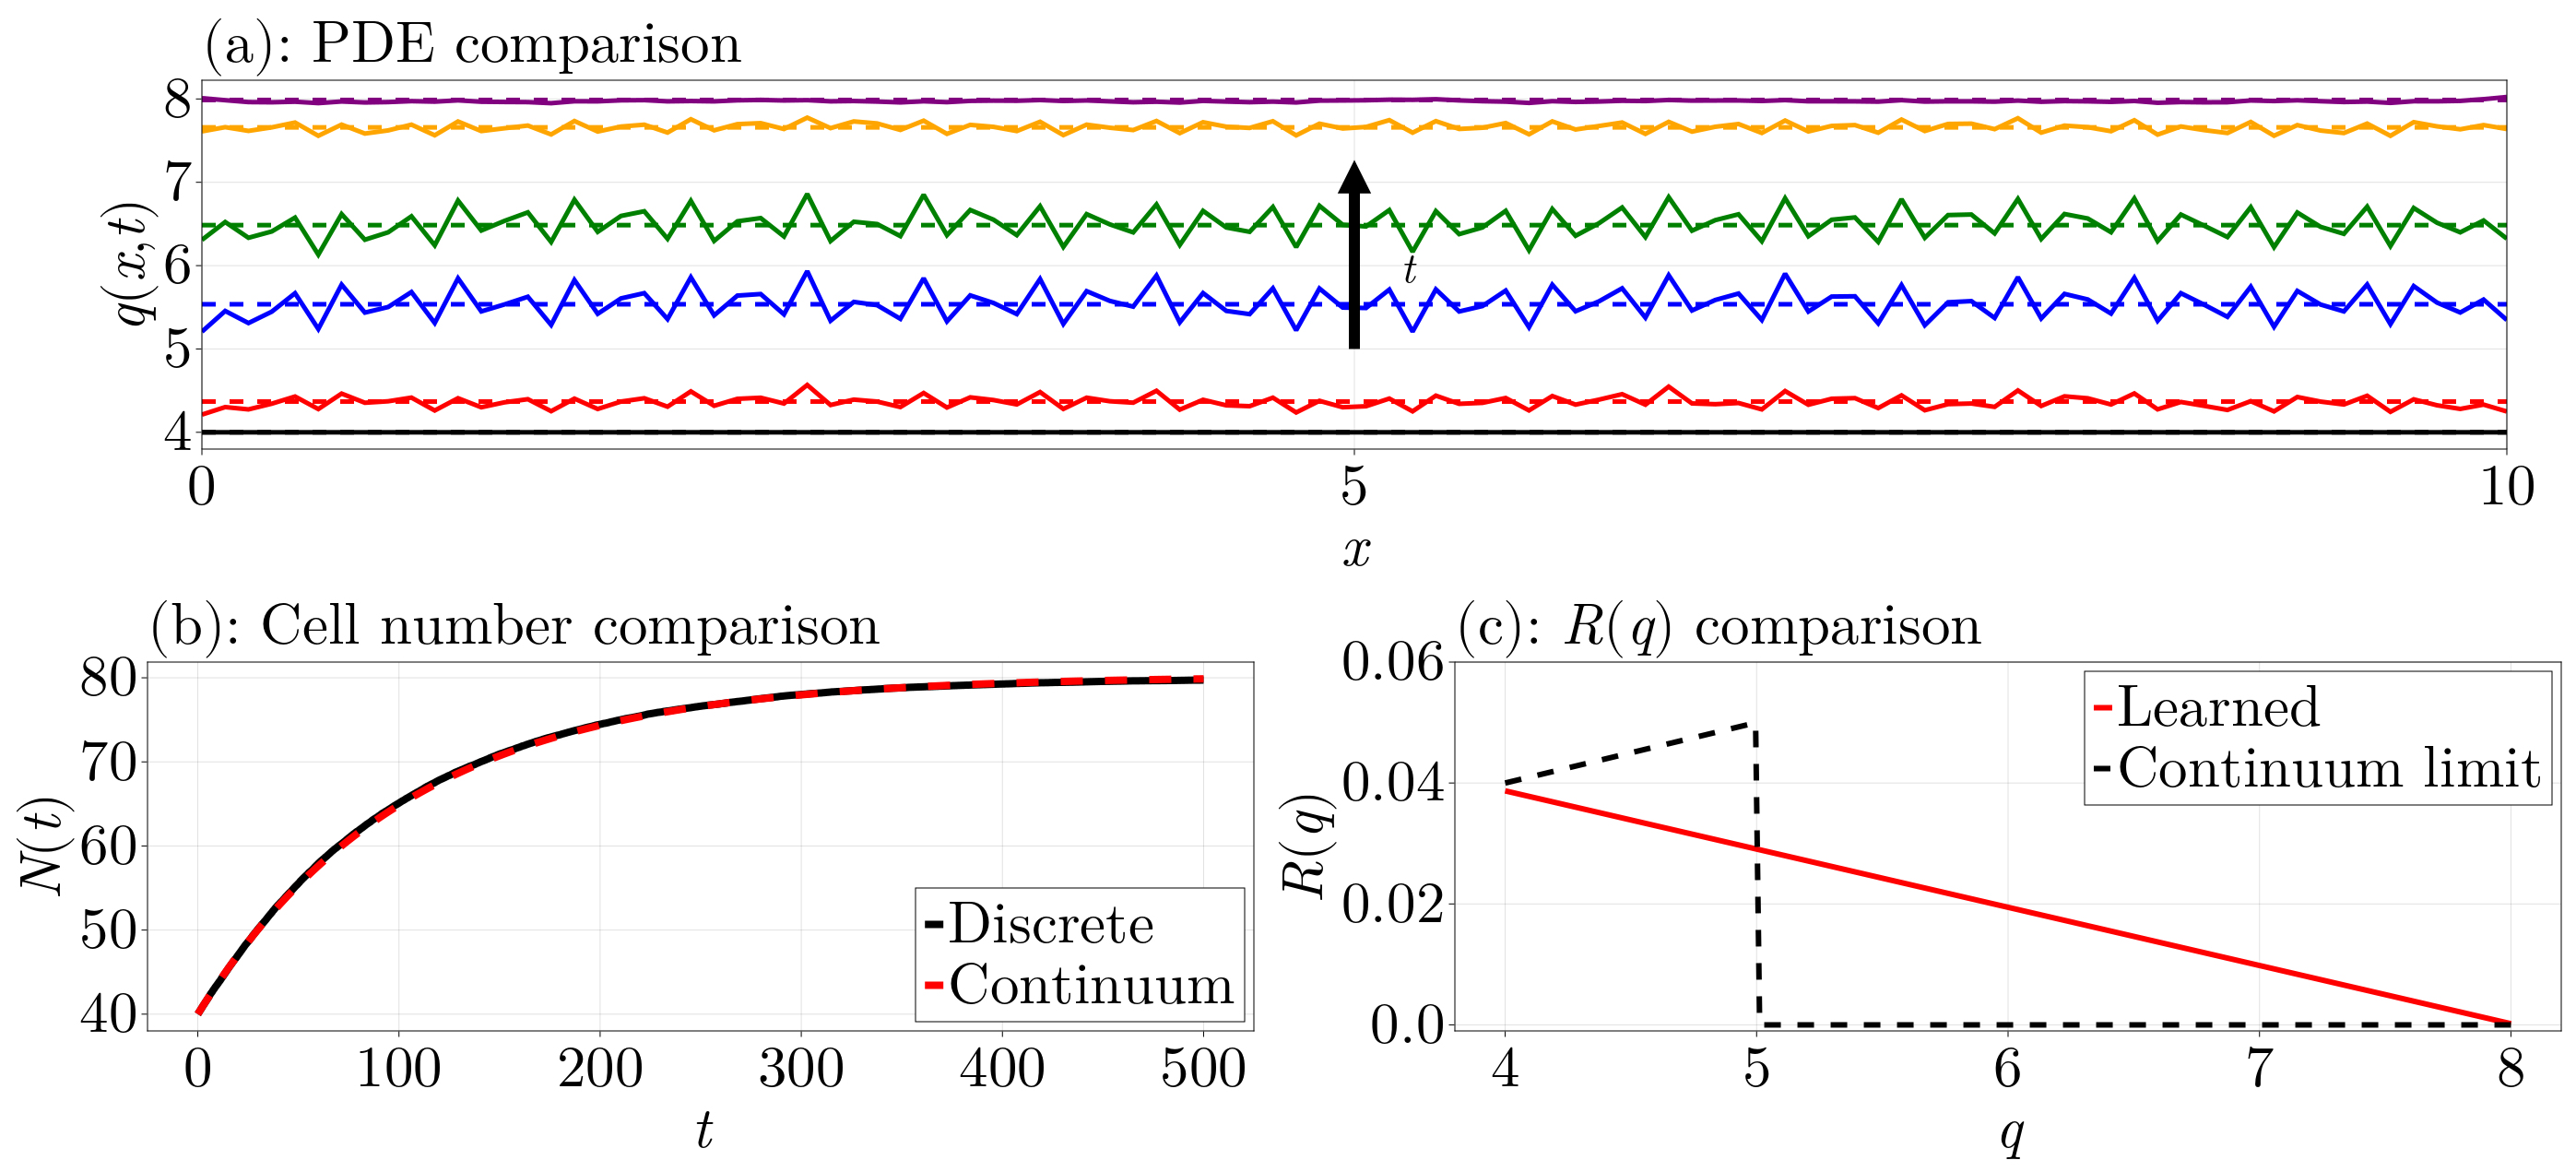

In [6]:
pde = eql_sol.pde
pde_sol = eql_sol.pde_sol
pde_number_results = [integrate_pde(pde_sol, i) for i in eachindex(pde_sol)]
fig = Figure(fontsize=63)
ax1 = Axis(fig[1, 1:2], xlabel=L"x", ylabel=L"q(x, t)",
    title=L"(a):$ $ PDE comparison", titlealign=:left,
    width=2500, height=400,
    xticks=(0:5:10, [L"%$s" for s in 0:5:10]),
    yticks=(4:8, [L"%$s" for s in 4:8]))
ax2 = Axis(fig[2, 1], xlabel=L"t", ylabel=L"N(t)",
    title=L"(b):$ $ Cell number comparison", titlealign=:left,
    width=1200, height=400,
    xticks=(0:100:500, [L"%$s" for s in 0:100:500]),
    yticks=(40:10:80, [L"%$s" for s in 40:10:80]))
ax3 = Axis(fig[2, 2], xlabel=L"q", ylabel=L"R(q)",
    title=L"(c): $R(q)$ comparison", titlealign=:left,
    width=1200, height=400,
    xticks=(4:8, [L"%$s" for s in 4:8]),
    yticks=(0:0.02:0.06, [L"%$s" for s in 0:0.02:0.06]))
for (j, i) in enumerate(t_idx)
    lines!(ax1, density_results.knots[i], density_results.means[i], color=colors[j], linewidth=5)
    lines!(ax1, pde.geometry.mesh_points, pde_sol.u[i], color=colors[j], linewidth=5, linestyle=:dash)
end
xlims!(ax1, 0, 10)
arrows!(ax1, [5.0], [5.0], [0.0], [2.0], color=:black, linewidth=12, arrowsize=50)
text!(ax1, [5.2], [5.7], text=L"t", color=:black, fontsize=47)
lines!(ax2, esol[1].t, number_results.means, color=:black, linewidth=8, label=L"$ $Discrete")
lines!(ax2, esol[1].t, pde_number_results, color=:red, linewidth=8, linestyle=:dash, label=L"$ $Continuum")
axislegend(ax2, position=:rb)
R_cont = q -> q * G(1 / q, Gp)
q_range = LinRange(4, 8, 250)
R_sol = reaction_basis.(q_range, Ref(eql_sol.reaction_theta), Ref(nothing))
R_cont_sol = R_cont.(q_range)
lines!(ax3, q_range, R_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
lines!(ax3, q_range, R_cont_sol, linewidth=6, color=:black, linestyle=:dash, label=L"$ $Continuum limit")
axislegend(ax3, position=:rt)
ylims!(ax3, -0.001, 0.06)
resize_to_layout!(fig)
fig

As we can now see, the results have significantly improved and we have learned
an accurate continuum model. Interestingly, the continuum form for $R(q)$ seems to
now be a line that goes through the endpoints of the continuum form of $R(q)$,
smoothing out the discontinuity, with $R(q) \approx \beta (K - q)$, where $K=8$; this form of
$R(q)$ is also of note, since the carrying capacity density for this problem is $q=K=8$, and
$\beta$ is the constant term in $G(\ell_i)$.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*